In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import losses, regularizers
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib notebook

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import torch

import torch.nn as nn
from torch.autograd import Function, Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F

In [4]:
def make_frames(data, dt = 0.1):
    # first four entries x. Next four y.
    x, vx, vy, y = data
    return np.hstack((x+vx*np.arange(-3,1)*dt, y+vy*np.arange(0,4)*dt))

In [128]:
np.arange(-3,1)

array([-3, -2, -1,  0])

In [5]:
t = 2
evolv_matrix = np.array([[1, t, 0, 0], [0, 1, 0, 0], [0, 0, -1, 0], [0, 0, -t, -1]])

## x' = x + vx*t
## vx' = vx
## vy' = -vy
## y' = -(y+vy*t)

In [6]:
data_zero = np.random.rand(5000,4)*np.array([1,1,-1,1])+np.array([0.5,0.5,-0.5,0.5]) # v_y negative, v_y<0.5. Wall is y=0
data_t = (evolv_matrix@data_zero.T).T

In [91]:
data_zero.shape

(5000, 4)

In [7]:
frames_zero = np.array([make_frames(data_zero[i]) for i in range(len(data_zero))])
frames_t = np.array([make_frames(data_t[i]) for i in range(len(data_t))])

In [8]:
X_train =frames_zero[:len(frames_zero)*4//5]
Y_train = frames_t[:len(frames_zero)*4//5]
X_test = frames_zero[len(frames_zero)*4//5:]
Y_test = frames_t[len(frames_zero)*4//5:]

In [85]:
min(Y_train[:,7])

-0.3390549471483571

In [10]:
weight=[np.array([[ 1.1712618 , -4.809617  ], \
        [-0.23456737, -1.0090216 ],\
        [ 0.21794164,  1.6582928 ],\
        [-1.3298252 ,  4.9579344 ],\
        [ 4.8249226 ,  0.6935729 ],\
        [ 1.0788591 ,  0.9836357 ],\
        [-1.9654702 , -0.47282606],\
        [-4.7279577 , -1.39693   ]]),\
 np.array([ 0.8412236, -1.321475 ]),\
 np.array([[ 1.3731354 , -0.78845894],\
        [ 0.9144167 ,  1.6326566 ]]),\
 np.array([-0.72670597,  1.2179112 ]),\
 np.array([[ 0.14669047,  0.15308473,  0.15947868,  0.16587289,  0.6894742 ,\
          0.71708626,  0.74469864,  0.7723107 ],\
        [ 0.59940106,  0.6263816 ,  0.6533616 ,  0.68034196, -0.23349167,\
         -0.24303403, -0.25257668, -0.2621189 ]]),\
 np.array([1.1055683 , 1.1345174 , 1.1634684 , 1.192418  , 0.0751679 ,\
        0.13770306, 0.20023818, 0.2627731 ])]


In [92]:
weight

[array([[ 1.1712618 , -4.809617  ],
        [-0.23456737, -1.0090216 ],
        [ 0.21794164,  1.6582928 ],
        [-1.3298252 ,  4.9579344 ],
        [ 4.8249226 ,  0.6935729 ],
        [ 1.0788591 ,  0.9836357 ],
        [-1.9654702 , -0.47282606],
        [-4.7279577 , -1.39693   ]]),
 array([ 0.8412236, -1.321475 ]),
 array([[ 1.3731354 , -0.78845894],
        [ 0.9144167 ,  1.6326566 ]]),
 array([-0.72670597,  1.2179112 ]),
 array([[ 0.14669047,  0.15308473,  0.15947868,  0.16587289,  0.6894742 ,
          0.71708626,  0.74469864,  0.7723107 ],
        [ 0.59940106,  0.6263816 ,  0.6533616 ,  0.68034196, -0.23349167,
         -0.24303403, -0.25257668, -0.2621189 ]]),
 array([1.1055683 , 1.1345174 , 1.1634684 , 1.192418  , 0.0751679 ,
        0.13770306, 0.20023818, 0.2627731 ])]

In [95]:
i=10
((weight[0].T@X_train[i]+weight[1])@weight[2]+weight[3])@weight[4]+weight[5]

array([1.73284376, 1.78993253, 1.84702255, 1.90411162, 0.17280805,
       0.23907458, 0.30534094, 0.37160736])

In [94]:
i=10
weight[0].T@X_train[i]@weight[2]@weight[4]+weight[1]@weight[2]@weight[4]+weight[3]@weight[4]+weight[5]

array([1.73284376, 1.78993253, 1.84702255, 1.90411162, 0.17280805,
       0.23907458, 0.30534094, 0.37160736])

In [101]:
A=weight[0]@weight[2]@weight[4]
B=weight[1]@weight[2]@weight[4]+weight[3]@weight[4]+weight[5]


In [130]:
weight[0]

array([[ 1.1712618 , -4.809617  ],
       [-0.23456737, -1.0090216 ],
       [ 0.21794164,  1.6582928 ],
       [-1.3298252 ,  4.9579344 ],
       [ 4.8249226 ,  0.6935729 ],
       [ 1.0788591 ,  0.9836357 ],
       [-1.9654702 , -0.47282606],
       [-4.7279577 , -1.39693   ]])

In [102]:
X_train[i].T@A+B

array([1.73284376, 1.78993253, 1.84702255, 1.90411162, 0.17280805,
       0.23907458, 0.30534094, 0.37160736])

In [112]:
A

array([[-5.66953199, -5.92414974, -6.17876189, -6.43337792,  0.12568861,
         0.13240266,  0.13911836,  0.14583119],
       [-1.05918178, -1.10659849, -1.15401402, -1.20143041, -0.51676186,
        -0.5371771 , -0.55759231, -0.57800775],
       [ 1.78616833,  1.86618941,  1.94620856,  2.02622909,  0.65979491,
         0.68573285,  0.71167063,  0.73760891],
       [ 5.8775713 ,  6.14157056,  6.40556403,  6.6695615 , -0.26802959,
        -0.28051442, -0.29300104, -0.30548459],
       [-0.53663438, -0.56230429, -0.58797501, -0.6136448 ,  5.62909212,
         5.85503761,  6.08098619,  6.30693131],
       [ 0.80198086,  0.83758327,  0.87318453,  0.90878668,  1.46519318,
         1.5237266 ,  1.58226056,  1.64079408],
       [ 0.00685251,  0.00781427,  0.00877658,  0.00973836, -2.34048663,
        -2.43436736, -2.52824931, -2.62212993],
       [-0.27232253, -0.28295939, -0.29359461, -0.30423134, -5.6947556 ,
        -5.92309625, -6.15143981, -6.37978025]])

In [113]:
from sympy import *

In [119]:
x1,x2,x3,x4,y1,y2,y3,y4=symbols('x1 x2 x3 x4 y1 y2 y3 y4')
init_printing(use_unicode=True)

In [123]:
simplify(x1*A[0,:]+x2*A[1]+x3*A[2]+x4*A[3]+y1*A[4]+y2*A[5]+y3*A[6]+y4*A[7])

In [122]:
A[0].shape

In [127]:
x1*A[0]+x2*A[1]+x3*A[2]+x4*A[3]+y1*A[4]+y2*A[5]+y3*A[6]+y4*A[7]

array([-5.66953198800709*x1 - 1.05918178473397*x2 + 1.78616833344366*x3 + 5.87757130410901*x4 - 0.536634380511821*y1 + 0.801980858635318*y2 + 0.00685250678314686*y3 - 0.272322533441004*y4,
       -5.9241497398475*x1 - 1.10659849204676*x2 + 1.86618941245174*x3 + 6.14157055638989*x4 - 0.562304288999677*y1 + 0.837583265245712*y2 + 0.00781426711253391*y3 - 0.282959385700351*y4,
       -6.17876188787288*x1 - 1.15401402376718*x2 + 1.94620855939757*x3 + 6.40556403203538*x4 - 0.587975005109429*y1 + 0.873184525921885*y2 + 0.00877657814493482*y3 - 0.29359461084452*y4,
       -6.43337792055858*x1 - 1.201430405603*x2 + 2.02622909121871*x3 + 6.66956150317583*x4 - 0.613644795631962*y1 + 0.908786677534074*y2 + 0.00973835504376641*y3 - 0.304231335105592*y4,
       0.125688607188176*x1 - 0.516761856393878*x2 + 0.659794912707619*x3 - 0.26802959205203*x4 + 5.62909211638156*y1 + 1.46519317565435*y2 - 2.34048663485596*y3 - 5.69475560496399*y4,
       0.132402659282424*x1 - 0.537177095765391*x2 + 0.68573284

In [31]:
Y_train[i]

array([1.73568999, 1.79074889, 1.84580779, 1.90086668, 0.1922554 ,
       0.24619425, 0.3001331 , 0.35407194])

In [37]:
(weight[0].T@X_train[i]+weight[1]).shape

(2,)

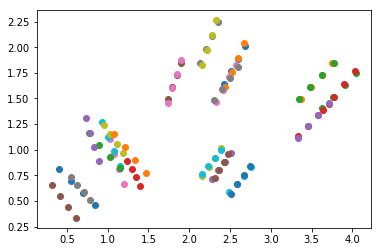

In [104]:
for i in range(20,30):

#     pred1=weight[0].T@X_train[i]+weight[1]
#     pred2=(weight[0].T@X_train[i]+weight[1])@weight[2]+weight[3]
    pred3=((weight[0].T@X_test[i]+weight[1])@weight[2]+weight[3])@weight[4]+weight[5]
    plt.plot(X_test[i][:4],X_test[i][4:],'o', label = 'train_frames')
#     plt.plot(pred1[0],pred1[1],'*')
#     plt.plot(pred2[0],pred2[1],'^')
    plt.plot(pred3[:4],pred3[4:],'o', label = 'train_frames')
    plt.plot(Y_test[i][:4],Y_test[i][4:],'o', label = 'train_frames')

In [ ]:
model = Sequential()
#model.add(Dense(8, input_dim=int(8), activation='relu'))
model.add(Dense(2, input_dim=int(8), activation='relu'))
model.add(Dense(2, activation='relu'))
#model.add(Dense(8, activation='relu'))
model.add(Dense(int(8)))
sgd = SGD(lr=0.2, decay=1e-4)

model.compile(optimizer=sgd,
              loss=losses.mean_squared_error,
              metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=150,batch_size=64)

Epoch 1/150


In [33]:
get_encoder_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])
get_decoder_input = K.function([model.layers[0].input],
                                  [model.layers[1].output])

In [34]:
get_encoder_output([X_train[:1]])[0]

array([[1.529591 , 1.7568989]], dtype=float32)

In [35]:
get_decoder_input([X_train[:1]])[0]

array([[3.2955775, 2.4150686]], dtype=float32)

In [36]:
X_train[0]

array([0.19593659, 0.33731669, 0.47869679, 0.6200769 , 1.2366937 ,
       1.0955375 , 0.95438131, 0.81322511])

In [ ]:
def slope(vec):
    return (vec[-1]-vec[4])/(vec[3]-vec[0])
def intersect(vec):
    return vec[4]-(vec[-1]-vec[4])/(vec[3]-vec[0])*vec[0]

In [136]:
i=0

plt.plot(X_train[0][:4],X_train[0][4:], color = 'C0', label = 'train_frames')
plt.plot(Y_train[0][:4],Y_train[0][4:], color = 'C1')

plt.plot([X_train[0][3], X_train[0][3] - X_train[0][-1]/slope(X_train[0])], [X_train[0][-1], 0],'--', color = 'C0',
        label = 'test_frames')
plt.plot([X_train[0][3] - X_train[0][-1]/slope(X_train[0]), Y_train[0][0]], [0, Y_train[0][4]],'--', color = 'C1')



plt.plot(pred[:4],pred[4:], color = 'C2')
plt.plot([pred[0] - pred[4]/slope(pred), pred[0]], [0, pred[4]],'--', color = 'C2', label = 'pred_frames')

plt.ylim(0,3)
plt.legend()

NameError: name 'model' is not defined

In [131]:
X_test.shape

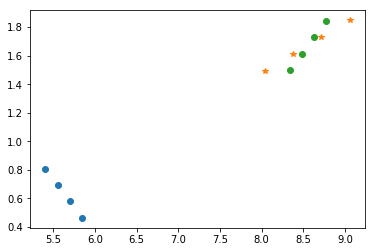

In [146]:
for i in range(20,21):

#     pred1=weight[0].T@X_train[i]+weight[1]
#     pred2=(weight[0].T@X_train[i]+weight[1])@weight[2]+weight[3]
    
    xtrain=np.hstack((X_test[i][:4]+5,X_test[i][4:]))
    pred3=((weight[0].T@(xtrain)+weight[1])@weight[2]+weight[3])@weight[4]+weight[5]
    plt.plot(5+X_test[i][:4],X_test[i][4:],'o', label = 'train_frames')
#     plt.plot(pred1[0],pred1[1],'*')
#     plt.plot(pred2[0],pred2[1],'^')
    plt.plot(pred3[:4],pred3[4:],'*', label = 'train_frames')
    plt.plot(5+Y_test[i][:4],Y_test[i][4:],'o', label = 'train_frames')

In [143]:
np.hstack((X_test[i][:4]+5,X_test[i][4:]))

array([5.54636318, 5.62671669, 5.70707021, 5.78742373, 0.73443352,
       0.6593435 , 0.58425349, 0.50916348])